In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
import math
print(tf.__version__)

1.10.0


Using TensorFlow backend.


In [2]:
# LOAD DATA
# manual method of separating data (not necessary)
# x_train = np.load("train_x.npy")
# arousal_y_train = np.load("arousal_train_y.npy")
# x_test = np.load("test_x.npy")
# arousal_y_test = np.load("arousal_test_y.npy")

# arousal_y_train = arousal_y_train.flatten()
# arousal_y_test = arousal_y_test.flatten()

audio_data = np.load("audio_data.npy")
arousal_labels = np.load("arousal_labels.npy")

x_train, x_test, arousal_y_train, arousal_y_test = train_test_split(
    audio_data, arousal_labels, test_size=0.5, random_state=0)

print("training set: {}".format(x_train.shape))
print("arousal_y_train: {}".format(arousal_y_train.shape))
print("testing set: {}".format(x_test.shape))
print("arousal_y_test: {}".format(arousal_y_test.shape))

training set: (901, 193)
arousal_y_train: (901,)
testing set: (901, 193)
arousal_y_test: (901,)


In [3]:
# Normalize the data

# Display sample features
print(x_train[0][1], type(x_train[0][1]))  

# another method of normalizing data
# Using mean and standard deviation
# mean = x_train.mean(axis=0)
# std = x_train.std(axis=0)
# x_train = (x_train - mean) / std
# x_test = (x_test - mean) / std

# Using keras utilities normalize
# scales data between 0 and 1
x_train = keras.utils.normalize(x_train, axis=1)  
x_test = keras.utils.normalize(x_test, axis=1)  

# notice the different scales
print(x_train[0][1], type(x_train[0][1]))

118.10459904226647 <class 'numpy.float64'>
0.6266310774136582 <class 'numpy.float64'>


In [4]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(193, activation=tf.nn.relu, 
                           input_shape=(x_train.shape[1],)),
        keras.layers.Dense(97, activation=tf.nn.relu),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(loss='mse',
                optimizer='adam', # 'rmsprop'
                metrics=['mae'])
    return model

aro_model = KerasRegressor(build_fn=build_model, 
                                 epochs=10, 
                                 batch_size=100, 
                                 verbose=0)

# this is to see the summary of what the build model() 
# function creates. aro_model is the model we're developing
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 193)               37442     
_________________________________________________________________
dense_1 (Dense)              (None, 97)                18818     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 98        
Total params: 56,358
Trainable params: 56,358
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Display training progress by printing a single dot for each 
# completed epoch. This is an example model training process
# using 500 iterations (EPOCHS)
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(x_train, arousal_y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [6]:
# This will plot a diagram that shows the mean absolute error

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Arousal]')
  plt.plot(history.epoch, 
           np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(
           history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,5])

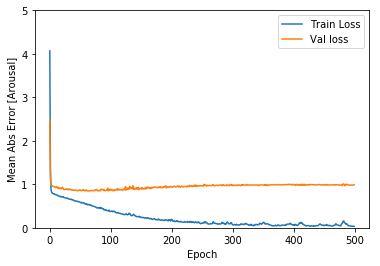

In [7]:
plot_history(history)


...............................................................................
....................................................................................................
...........................

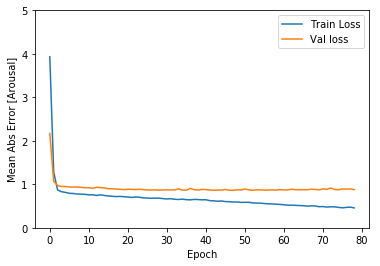

In [8]:
# This will re-initialize the building of the model. 
# Fresh start not trained
model = build_model()

# The patience parameter is the amount of epochs to check for 
# improvement. Once the model isn't improving after 20 epochs,
# the training will stop
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20)

# this is just for showing the diagram again using the dummy model
history = model.fit(x_train, arousal_y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])
# plotting
plot_history(history)

# we will now train the actual model like this. 
# Seems to be a good idea
aro_model.fit(x_train, arousal_y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

In [9]:
# The actual model will be subjected to cross validation now
scores = cross_val_score(
    aro_model, 
    x_test, 
    arousal_y_test, 
    scoring='neg_mean_squared_error', 
    cv=10)

# Results
# Sir Ken and Sir Capao say that the rmse value is acceptable 
# close to 0 is good from what I remember
print("\nTesting Set mean squared error:",abs(scores.mean()))
rmse = math.sqrt(abs(scores.mean()))
print("Testing Set root mean squared error:", rmse)
[loss, mae] = model.evaluate(x_test, arousal_y_test, verbose=0)
print("Testing set Loss:{:7.2f}".format(loss))
print("Testing set Mean Abs Error:{:7.2f}".format(mae))


Testing Set mean squared error: 1.0319119969349895
Testing Set root mean squared error: 1.0158306930463312
Testing set Loss:   1.09
Testing set Mean Abs Error:   0.81


In [10]:
# we will now let the model predict
test_predictions = aro_model.predict(x_test).flatten()
# test_predictions are the predictions given by the model
print(len(test_predictions))
print(len(arousal_y_test))

901
901


In [11]:
# this is the summary of comparison between the expected values
# and the predicted values. 
less_than_one=0 # 0.1-0.9 difference
less_than_two=0 # 1.0-1.9 difference
less_than_three=0 # 2.0-2.9 difference
not_manageable=0 # 3.0 and beyond

for i in range(len(arousal_y_test)):
    diff = abs(test_predictions[i] - arousal_y_test[i])
    if(diff < 1):
        less_than_one = less_than_one + 1
    elif(diff < 2):
        less_than_two = less_than_two + 1
    elif(diff < 3):
        less_than_three = less_than_three + 1
    else:
        not_manageable = not_manageable + 1
        print("test[{}] - values different by {:.1f}".format(i,diff))
    print("test[{0:}] - expected: {1:.1f}, prediction: {2:.1f}".format(i,test_predictions[i],arousal_y_test[i]))
print("Summary of Differences:\nLess than one: {}\nLess than two: {}\nLess than three: {}\nUnmanageable: {}".format(less_than_one,less_than_two,less_than_three,not_manageable))


# print("test[436] - expected: {0:.1f}, prediction: {1:.1f}".format(test_predictions[436],valence_y_test[436]))

test[0] - expected: 5.8, prediction: 6.7
test[1] - expected: 4.3, prediction: 3.6
test[2] - expected: 5.0, prediction: 5.7
test[3] - expected: 5.9, prediction: 6.5
test[4] - expected: 8.0, prediction: 5.8
test[5] - expected: 4.5, prediction: 3.9
test[6] - expected: 5.5, prediction: 5.7
test[7] - expected: 3.6, prediction: 2.6
test[8] - expected: 5.4, prediction: 6.2
test[9] - expected: 4.6, prediction: 6.2
test[10] - expected: 3.9, prediction: 4.4
test[11] - expected: 3.8, prediction: 3.3
test[12] - expected: 3.6, prediction: 3.2
test[13] - expected: 5.4, prediction: 4.1
test[14] - expected: 4.9, prediction: 5.1
test[15] - expected: 4.0, prediction: 4.7
test[16] - expected: 6.0, prediction: 6.4
test[17] - expected: 5.4, prediction: 6.3
test[18] - expected: 5.2, prediction: 7.6
test[19] - expected: 5.8, prediction: 5.7
test[20] - expected: 4.2, prediction: 3.3
test[21] - expected: 4.1, prediction: 3.2
test[22] - expected: 5.8, prediction: 4.4
test[23] - expected: 5.4, prediction: 5.3
te

In [16]:
print("Test Samples Accounted for: {}/{}".format(
    less_than_one+less_than_two+less_than_three+not_manageable,
    len(arousal_y_test)))

acc1 = less_than_one/len(arousal_y_test)
acc2 = (less_than_one+less_than_two)/len(arousal_y_test)
acc3 = (less_than_one+less_than_two+less_than_three)/len(arousal_y_test)

print("Accuracy Percentage:")
print("Taking into consideration predictions off by decimals: {0:} / {1:} = {2:.6f}".format(
    less_than_one,len(arousal_y_test),acc1))
print("If we include predictions off by 1._: {0:} / {1:} = {2:.6f}".format(
    less_than_one+less_than_two, 
    len(arousal_y_test),
    acc2))
print("If we include predictions off by 2._: {0:} / {1:} = {2:.6f}".format(
    less_than_one+less_than_two+less_than_three,
    len(arousal_y_test),
    acc3))

Test Samples Accounted for: 901/901
Accuracy Percentage:
Taking into consideration predictions off by decimals: 646 / 901 = 0.716981
If we include predictions off by 1._: 851 / 901 = 0.944506
If we include predictions off by 2._: 897 / 901 = 0.995560


In [19]:
# Saving, Loading and Testing Models
arousal_regressor = build_model()
arousal_regressor.fit(x_train, arousal_y_train, epochs=EPOCHS,
                     validation_split=0.2, verbose=0,
                     callbacks=[early_stop, PrintDot()])
arousal_regressor.save('audio_nn_arousal_regressor.model')
# loaded_arousal_model = tf.keras.models.load_model('audio_nn_arousal_regressor.model')
# arousal_predictions = loaded_arousal_model.predict(x_test)


..................................................................................